In [ ]:
import numpy as np
import pygame
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import torch.nn.functional as F

In [ ]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

pygame 2.6.1 (SDL 2.28.4, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class Obstacle:
    def __init__(self, x, height, width, is_bird=False, image=None):
        self.x = x
        self.height = height
        self.width = width
        self.is_bird = is_bird
        self.y = 0 if is_bird else None
        self.image = image
        
class Cloud:
    def __init__(self, x, y, image):
        self.x = x
        self.y = y
        self.image = image
        self.speed = 1  # Velocidad de desplazamiento de la nube hacia la izquierda

    def update(self):
        # Mueve la nube hacia la izquierda
        self.x -= self.speed
        # Reposiciona la nube si se ha salido de la pantalla
        if self.x < -self.image.get_width():
            self.x = 800 + random.randint(50, 200)  # Reposiciona a la derecha de la pantalla
            self.y = random.randint(50, 150)  # Genera una nueva altura

In [ ]:

class DinoGame:
    def __init__(self):
        pygame.init()
        self.width = 800
        self.height = 300
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption('Dino Game')
        
        # Cargar la imagen del piso
        self.ground_img = pygame.image.load('assets/ground.png').convert_alpha()
        self.ground_img = pygame.transform.scale(self.ground_img, (self.width, self.ground_img.get_height()))
        
        # Posición inicial del piso para el bucle
        self.ground_x1 = 0
        self.ground_x2 = self.width  # Segunda imagen a la derecha de la primera
        
        # Cargar imágenes del dinosaurio
        self.dino_run_imgs = [
            pygame.image.load('assets/dino_run1.png').convert_alpha(),
            pygame.image.load('assets/dino_run2.png').convert_alpha()
        ]
        
        self.dino_duck_imgs = [
            pygame.image.load('assets/dino_duck1.png').convert_alpha(),
            pygame.image.load('assets/dino_duck2.png').convert_alpha()
        ]
        
        # Cargar imágenes de obstáculos
        self.cactus_imgs = [
            pygame.image.load('assets/cactus1.png').convert_alpha(),
            pygame.image.load('assets/cactus2.png').convert_alpha(),
            pygame.image.load('assets/cactus3.png').convert_alpha(),
            pygame.image.load('assets/cactus4.png').convert_alpha(),
            pygame.image.load('assets/cactus5.png').convert_alpha(),
            pygame.image.load('assets/cactus6.png').convert_alpha()
        ]
        
        self.bird_imgs = [
            pygame.image.load('assets/bird1.png').convert_alpha(),
            pygame.image.load('assets/bird2.png').convert_alpha()
        ]
        
        # Cargar la imagen de la nube
        self.cloud_img = pygame.image.load('assets/cloud.png').convert_alpha()
        
        # Escalar la imagen de la nube
        self.cloud_img = pygame.transform.scale(self.cloud_img, 
                                                (int(self.cloud_img.get_width() * 3), 
                                                int(self.cloud_img.get_height() * 3)))
        
        # Crear una lista de nubes
        self.clouds = [Cloud(random.randint(800, 1600), random.randint(50, 150), self.cloud_img)
                        for _ in range(3)]  # Crea 3 nubes
        
        # Dinosaur configuration
        self.dino_height = 40
        self.dino_width = 20
        self.dino_x = 50
        self.dino_y = self.height - self.dino_run_imgs[0].get_height()
        self.dino_vel = 0
        self.jump_vel = -15
        self.gravity = 0.8
        self.is_ducking = False
        self.duck_height = self.dino_height // 2
        
        # Índices para animaciones
        self.dino_run_index = 0
        self.dino_duck_index = 0
        self.bird_index = 0
        
        # Obstaculos
        self.obstacles = []
        self.bird_heights = [self.height - 120, self.height - 80] # Altura permitida de pájaros
        
        # Espacio mínimo entre obstáculos
        self.absolute_min_spacing = 400
        self.last_obstacle_x = None
        self.max_obstacles = 2
        
        # Dificultad del juego
        self.base_speed = 5
        self.current_speed = self.base_speed
        self.speed_increment = 0.05
        self.max_speed = 12
        
        self.score = 0
        self.game_over = False
        self.clock = pygame.time.Clock()
        self.paused = False
        self.bestScore = 0
    
    def handle_events(self):
        pygame.event.pump()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                return False
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_SPACE:
                    self.paused = not self.paused
                elif event.key == pygame.K_ESCAPE:
                    pygame.quit()
                    return False
        return True
    
    def reset(self):
        self.dino_y = self.height - self.dino_height
        self.dino_vel = 0
        self.obstacles = []
        self.score = 0
        self.game_over = False
        self.paused = False
        self.current_speed = self.base_speed
        self.is_ducking = False
        self.last_obstacle_x = None
        return self._get_state()
    
    def _get_state(self):
        closest_obstacles = sorted(self.obstacles, key=lambda x: x.x)[:2]
        state = []
        
        # Añadir información de los dos obstáculos más cercanos
        for i in range(2):
            if i < len(closest_obstacles):
                obs = closest_obstacles[i]
                state.extend([
                    obs.x - self.dino_x,
                    obs.height,
                    obs.y if obs.is_bird else 0 # Posición relativa al suelo
                ])
            else:
                state.extend([self.width, 0, 0])
        
        # Agregar stado del dinosaurio
        state.extend([
            self.dino_y,
            self.dino_vel,
            self.current_speed
        ])
        
        return np.array(state)
    
    def _can_spawn_obstacle(self):
        if len(self.obstacles) >= self.max_obstacles:
            return False
            
        if not self.obstacles:
            return True if self.last_obstacle_x is None else False
            
        rightmost_x = max(obstacle.x for obstacle in self.obstacles)
        required_spacing = self.absolute_min_spacing + (self.current_speed * 20)
        
        return rightmost_x <= (self.width - required_spacing)
    
    def _spawn_obstacle(self):
        if not self._can_spawn_obstacle():
            return
            
        is_bird = random.random() < 0.2
        
        if is_bird:
            obstacle_img = self.bird_imgs[0]
            obstacle = Obstacle(self.width, obstacle_img.get_height(), obstacle_img.get_width(), is_bird=True, image=obstacle_img)
            obstacle.y = random.choice(self.bird_heights)
            obstacle.y = random.choice(self.bird_heights)
        else:
            obstacle_img = random.choice(self.cactus_imgs)
            obstacle = Obstacle(self.width, obstacle_img.get_height(), obstacle_img.get_width(), is_bird=False, image=obstacle_img)
        
        self.obstacles.append(obstacle)
        self.last_obstacle_x = self.width
    
    def step(self, action):
        if not self.handle_events() or self.paused:
            return self._get_state(), 0, True

        reward = 0.1
        
        if action == 1 and self.dino_y >= self.height - self.dino_height:
            self.dino_vel = self.jump_vel
            self.is_ducking = False
        elif action == 2 and self.dino_y >= self.height - self.dino_height:
            self.is_ducking = True
        else:
            self.is_ducking = False
        
        self.dino_y += self.dino_vel
        self.dino_vel += self.gravity
        
        if self.dino_y > self.height - (self.duck_height if self.is_ducking else self.dino_height):
            self.dino_y = self.height - (self.duck_height if self.is_ducking else self.dino_height)
            self.dino_vel = 0
        
        if len(self.obstacles) > 0:
            self.current_speed = min(self.max_speed, 
                                   self.base_speed + self.speed_increment * self.score)
        
        any_obstacle_passed = False
        for obstacle in self.obstacles[:]:
            obstacle.x -= self.current_speed
            if obstacle.x < -obstacle.width:
                self.obstacles.remove(obstacle)
                any_obstacle_passed = True
        
        if any_obstacle_passed:
            self.score += 1
            reward = 1.0
        
        if self._can_spawn_obstacle():
            self._spawn_obstacle()
        
        collitionObstacle = self._check_collision()
        if collitionObstacle is not None:
            reward = -10.0
            self.game_over = True
            
            # Si choca con cactus estándo agachado o en el piso, mayor penalización
            if not collitionObstacle.is_bird and (self.is_ducking or self.dino_y >= self.height - self.dino_height):
                reward -= 2.0
        
        return self._get_state(), reward, self.game_over
    
    def _check_collision(self):
        if self.is_ducking:
            dino_img = self.dino_duck_imgs[0]
        else:
            dino_img = self.dino_run_imgs[0]
        dino_rect = dino_img.get_rect(topleft=(self.dino_x, self.dino_y))
        
        for obstacle in self.obstacles:
            obstacle_rect = obstacle.image.get_rect()
            if obstacle.is_bird:
                obstacle_rect.topleft = (obstacle.x, obstacle.y)
            else:
                obstacle_rect.bottomleft = (obstacle.x, self.height)

            if dino_rect.colliderect(obstacle_rect):
                return obstacle
        return None
    
    def render(self):
        self.screen.fill((255, 255, 255))
        
        # Dibujar las nubes en el fondo
        for cloud in self.clouds:
            cloud.update()
            self.screen.blit(cloud.image, (cloud.x, cloud.y))
            
        # Dibujar el piso con desplazamiento infinito
        self.ground_x1 -= self.current_speed
        self.ground_x2 -= self.current_speed
        
        # Si una imagen del piso sale de la pantalla, reubicarla al extremo derecho
        if self.ground_x1 <= -self.width:
            self.ground_x1 = self.width
        if self.ground_x2 <= -self.width:
            self.ground_x2 = self.width

        # Dibujar ambas imágenes del piso para crear el efecto de bucle
        self.screen.blit(self.ground_img, (self.ground_x1, self.height - self.ground_img.get_height()))
        self.screen.blit(self.ground_img, (self.ground_x2, self.height - self.ground_img.get_height()))
        
        # Actualizar índice de animación del dinosaurio
        if self.is_ducking:
            self.dino_duck_index = (self.dino_duck_index + 0.2) % len(self.dino_duck_imgs)
            dino_img = self.dino_duck_imgs[int(self.dino_duck_index)]
        else:
            self.dino_run_index = (self.dino_run_index + 0.2) % len(self.dino_run_imgs)
            dino_img = self.dino_run_imgs[int(self.dino_run_index)]
        
        # Dibujar al dinosaurio
        self.screen.blit(dino_img, (self.dino_x, self.dino_y))
        
        # Dibujar los obstáculos
        for obstacle in self.obstacles:
            if obstacle.is_bird:
                # Animación del ave
                self.bird_index = (self.bird_index + 0.1) % len(self.bird_imgs)
                obstacle.image = self.bird_imgs[int(self.bird_index)]
                self.screen.blit(obstacle.image, (obstacle.x, obstacle.y))
            else:
                self.screen.blit(obstacle.image, (obstacle.x, self.height - obstacle.image.get_height()))
        
        # Dibujar labels de score y velocidad
        font = pygame.font.Font(None, 36)
        score_text = font.render(f'Score: {self.score}', True, (0, 0, 0))
        speed_text = font.render(f'Speed: {self.current_speed:.1f}', True, (0, 0, 0))
        bestscore_text = font.render(f'Best Score: {self.bestScore}', True, (0, 0, 0))
        self.screen.blit(score_text, (10, 10))
        self.screen.blit(speed_text, (10, 40))
        self.screen.blit(bestscore_text, (self.width - 200, 10))
        
        if self.paused:
            pause_text = font.render('PAUSED', True, (255, 0, 0))
            text_rect = pause_text.get_rect(center=(self.width/2, self.height/2))
            self.screen.blit(pause_text, text_rect)
        
        pygame.display.flip()
        self.clock.tick(60)

In [ ]:

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.learning_rate = 0.001
        self.memory = deque(maxlen=200000)
        
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        self.update_target_model()
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            act_values = self.model(state)
            return torch.argmax(act_values).item()
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return None
        
        minibatch = random.sample(self.memory, batch_size)
        states = torch.FloatTensor([t[0] for t in minibatch])
        actions = torch.LongTensor([t[1] for t in minibatch])
        rewards = torch.FloatTensor([t[2] for t in minibatch])
        next_states = torch.FloatTensor([t[3] for t in minibatch])
        dones = torch.FloatTensor([t[4] for t in minibatch])
        
        current_q = self.model(states).gather(1, actions.unsqueeze(1))
        
        with torch.no_grad():
            max_next_q = self.target_model(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * max_next_q
        
        loss = F.mse_loss(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        return loss.item()

In [2]:
# Listas para almacenar métricas
episode_rewards = []
episode_losses = []
episode_epsilons = []
episode_lengths = []

In [ ]:

def train_dino():
    env = DinoGame()
    state_size = 9
    action_size = 3
    agent = DQNAgent(state_size, action_size)
    batch_size = 32
    episodes = 1000
    
    bestScore = 0
    try:
        for episode in range(episodes):
            state = env.reset()
            total_reward = 0
            total_loss = 0
            steps_in_episode = 0
            step = 0
            
            while not env.game_over:
                action = agent.act(state)
                next_state, reward, done = env.step(action)
                
                if done and not env.paused:
                    total_reward += reward
                    agent.remember(state, action, reward, next_state, done)
                    agent.replay(batch_size)
                elif not env.paused:
                    total_reward += reward
                    agent.remember(state, action, reward, next_state, done)
                    agent.replay(batch_size)
                
                state = next_state
                env.render()           
                
                if episode % 10 == 0:
                    
                    agent.update_target_model()
                    
                if env.score > bestScore:
                    bestScore = env.score
                    env.bestScore = bestScore
            
            print(f"Episodio: {episode + 1}, Score: {total_reward}, Epsilon: {agent.epsilon}, Memoria: {len(agent.memory)}")
            
        
            # Guardar modelo si tiene un mejor puntaje
            if total_reward > bestScore:
                bestScore = total_reward
                torch.save(agent.model.state_dict(), 'best_dino_model.pth')
                print(f"Mejor modelo guardado con puntaje: {total_reward}")
    
    except KeyboardInterrupt:
        print("\nEntrenamiento interrumpido por el usuario")
    finally:
        pygame.quit()

In [ ]:
import matplotlib.pyplot as plt

# Listas para almacenar métricas
episode_rewards = []
episode_losses = []
episode_epsilons = []
episode_lengths = []

def train_dino():
    env = DinoGame()
    state_size = 12
    action_size = 3
    agent = DQNAgent(state_size, action_size)
    batch_size = 64
    episodes = 1000
    best_score = -float('inf')

    try:
        for episode in range(episodes):
            state = env.reset()
            total_reward = 0
            total_loss = 0
            steps_in_episode = 0
            step = 0

            while not env.game_over:
                action = agent.act(state)
                next_state, reward, done = env.step(action)
                
                # Premios incrementales por mantenerse vivo
                if not done:
                    reward += 0.05
                if state.tolist() == next_state.tolist() and reward == 0.1:
                    reward = -0.2
                    
                # Penalización por acciones repetitivas en el mismo estado
                if state.tolist() == next_state.tolist() and reward == 0.1:
                    reward = -0.2  

                total_reward += reward
                agent.remember(state, action, reward, next_state, done)

                # Llama replay() con menor frecuencia
                if len(agent.memory) >= batch_size:
                    loss = agent.replay(batch_size)
                    if loss is not None:
                        total_loss += loss
                        step += 1
                
                state = next_state
                env.render()
                steps_in_episode += 1

                if done:
                    agent.update_target_model()
                    
            # Calcular pérdida promedio por episodio
            avg_loss = total_loss / step if step > 0 else 0
            episode_rewards.append(total_reward)
            episode_losses.append(avg_loss)
            episode_epsilons.append(agent.epsilon)
            episode_lengths.append(steps_in_episode)

            # Guardar el mejor modelo
            if total_reward > best_score:
                best_score = total_reward
                torch.save(agent.model.state_dict(), 'best_dino_model.pth')
                print(f"Mejor modelo guardado con puntaje: {total_reward}")

            # Guardar modelo si tiene un mejor puntaje
            if total_reward > best_score:
                best_score = total_reward
                torch.save(agent.model.state_dict(), 'best_dino_model.pth')
                print(f"Mejor modelo guardado con puntaje: {total_reward}")
            
            print(f"Episodio: {episode + 1}, Puntaje: {total_reward}, Epsilon: {agent.epsilon}")
            
    except KeyboardInterrupt:
        print("Entrenamiento interrumpido")
        
    finally:
        pygame.quit()

if __name__ == "__main__":
    train_dino()

Mejor modelo guardado con puntaje: 27.499999999999837
Episodio: 1, Puntaje: 27.499999999999837, Epsilon: 0.4016064652978155
Episodio: 2, Puntaje: 13.699999999999953, Epsilon: 0.18099664897669618
Entrenamiento interrumpido


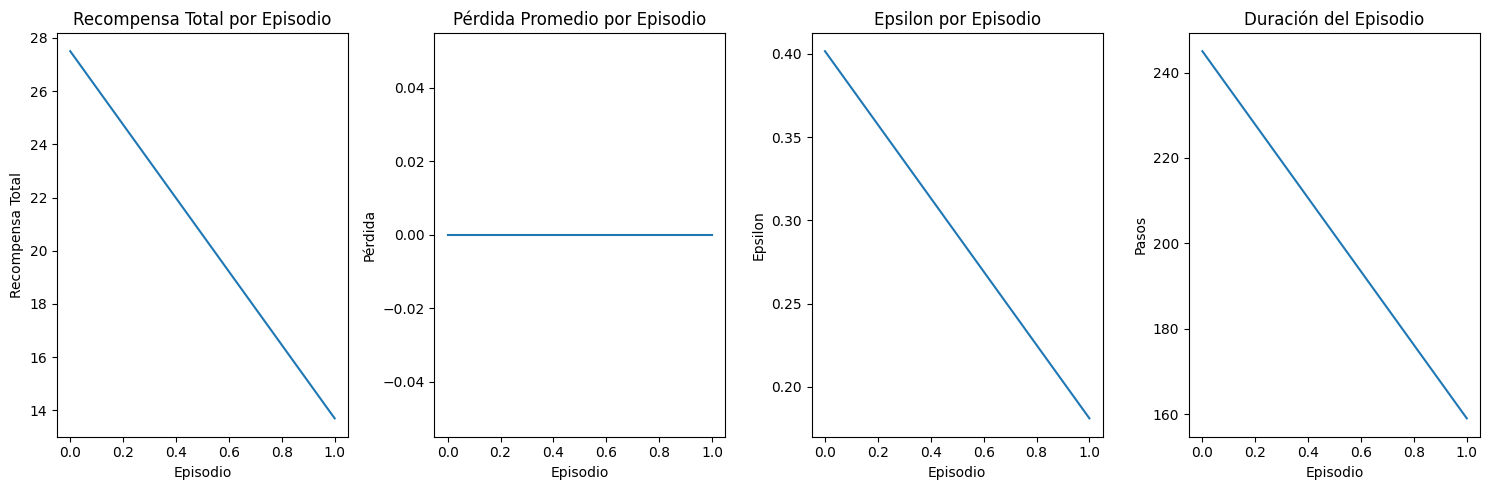

In [8]:
# Después del entrenamiento, graficar las métricas
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.plot(episode_rewards)
plt.title('Recompensa Total por Episodio')
plt.xlabel('Episodio')
plt.ylabel('Recompensa Total')

plt.subplot(1,4,2)
plt.plot(episode_losses)
plt.title('Pérdida Promedio por Episodio')
plt.xlabel('Episodio')
plt.ylabel('Pérdida')

plt.subplot(1,4,3)
plt.plot(episode_epsilons)
plt.title('Epsilon por Episodio')
plt.xlabel('Episodio')
plt.ylabel('Epsilon')

plt.subplot(1,4,4)
plt.plot(episode_lengths)
plt.title('Duración del Episodio')
plt.xlabel('Episodio')
plt.ylabel('Pasos')

plt.tight_layout()
plt.show()